In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
# type(mnist): sklearn.utils.Bunch
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']
# ‘data’数据为70000x784矩阵， 即70000张28x28的图片
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


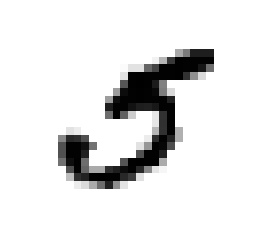

label: 5.0


In [4]:
# %matplotlib inline 是IPython内部定义的宏，用于在jupyter notebook便捷地显示图像
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# 显示数据集中的图像
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()
print("label:", y[36000])

In [5]:
# Split training set and test set
# The MNIST dataset is actually already split into a training set 
# (the first 60,000 images) and a test set (the last 10,000 images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

In [7]:
# Training a binary classifier
# 以5为例，训练一个分类器用于识别5和非5数字
# 这里我们先创建一个label数组用于标记数字是否为5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
# SGDClassifier (Stochastic Gradient Descent)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
# Measuring SGD
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9515 , 0.9603 , 0.95925])

In [11]:
# Implementing Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    print("Split:",len(y_train_folds), "/", len(y_test_fold))
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_test_fold))


Split: 40000 / 20000
0.9515
Split: 40000 / 20000
0.9603
Split: 40000 / 20000
0.95925


In [12]:
# 这里我们创建一个非常蠢的分类器，用于区分所有非5的数字，然后所有值都返回false
# 问题在于这个分类器在cross_val_score中依然取得90%左右的准确率！！！
# 说明cross_val_score评分机制有缺陷
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9111 , 0.90995, 0.9079 ])

In [13]:
# Confusion Matrix 评分
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53728,   851],
       [ 1728,  3693]])

In [14]:
# Perfect Prediction
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [15]:
# Precision & Recall
from sklearn.metrics import precision_score, recall_score
print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))

Precision: 0.8127200704225352
Recall: 0.6812396236856668


In [16]:
# F1 Score

# F1评分是Precision和Recall的综合评分，只有当Precision和Recall得分较高时

# F1的评分才会比较高。某些情况下评分标准可能需要偏向Precision或Recall

# 例如：过滤出儿童适合看的视频，我们需要较高的Precision来确保每个视频都是OK的

# 例如：安全监控录像，需要较高的Recall来确保每个事件都能被录到，虽然会引入其他不准确的视频

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7411941796287005

In [17]:
# 获取一个评分，可以用于自定义threshold
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([171727.74122313])

In [18]:
# 我们把threshold定义为0，结果为True
threshold = 0
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

array([ True])

In [19]:
# 把threshold提高到200000，结果变为False
threshold = 200000
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

array([False])

In [20]:
# use decision_function to get the score
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  -90554.01495984, -1228066.78865521,  -279206.7445754 , ...,
        -198055.74529231,   -90770.18665769,   -28543.06114961])

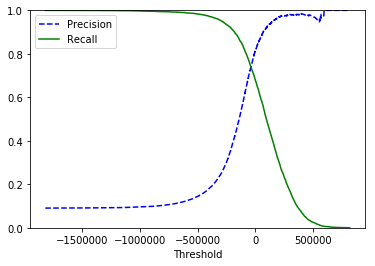

In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#Precision 线条表现会有抖动，Recall线条表现更为平稳

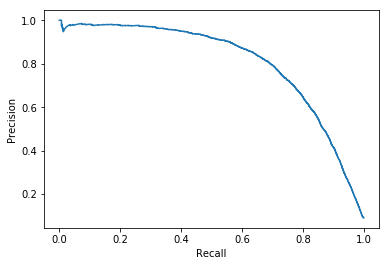

In [22]:
# Precision与Recall的关系，整体上呈相反关系
# 在线条开始下跌之前的那段是不错的取值区间
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [23]:
# 假设我们要一个Precision为90%，可以这么做
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
threshold = 130000 # 这里我们通过尝试，找到了这么一个数字
y_precision_90 = (y_scores > threshold)
print("Precision:", precision_score(y_train_5, y_precision_90))
print("Recall:", recall_score(y_train_5, y_precision_90))

Precision: 0.9381158849034292
Recall: 0.4390333886736764


In [24]:
# ROC曲线(Reveiver Operating Characteristic)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

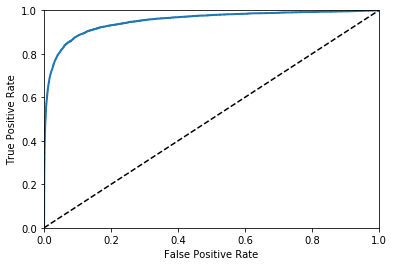

In [25]:
# plot roc curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') ## 对角虚线
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
# ROC AUC(Area Under Curve)分数，可以理解为上图中ROC覆盖的面积
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9516689943057584

In [27]:
# ROC曲线与Precision-Recall曲线对比

# 如果Positive的样本比较少，使用PR曲线

# PR曲线更注重False Positive
# ROC曲线更注重 False Negatives

In [28]:
# Compare Random Forest Classifier
# RandomForestClassifier没有decision_function, 
# 只能用predict_proba,返回值是可能性百分数
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")
y_probas_forest

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [29]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [30]:
thresholds_forest # threshold的取值范围会根据对比数组变化

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ])

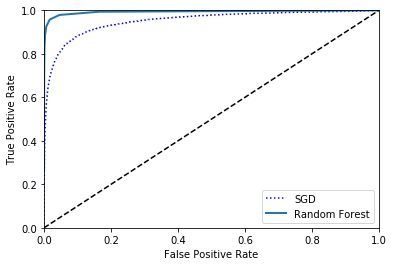

ROC AUC Score of SGD:           0.9516689943057584
ROC AUC Score of Random Forest: 0.9933079797319225


In [31]:
# ROC曲线图
plt.plot(fpr, tpr, "b:", label="SGD") #显示SGD算法的ROC曲线
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# ROC AUC 分数
print("ROC AUC Score of SGD:          ", roc_auc_score(y_train_5, y_scores))
print("ROC AUC Score of Random Forest:", roc_auc_score(y_train_5, y_scores_forest))

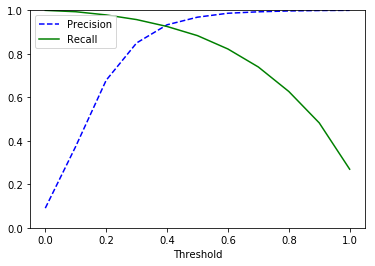

In [32]:
# 查看RandomForestClassifier的PR曲线
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
                                                        y_train_5, y_scores_forest)
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest,
                                   thresholds_forest)
plt.show()

In [33]:
# Random Forest Classifier 的 Precision, Reall 和 F1 分数
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("Precision:", precision_score(y_train_5, y_train_pred_forest))
print("Recall:", recall_score(y_train_5, y_train_pred_forest))
print("F1 Score:", f1_score(y_train_5, y_train_pred_forest))

#结论：RandomForestClassifier明显比SGDClassifier要更优秀

Precision: 0.9867197875166003
Recall: 0.8223574986164914
F1 Score: 0.8970721400543314


# Multiclass Classification

### OvA (one-vs-all) 策略
比如Random Forest classifiers， naive Bayes classifiers

所需的分类器跟最终分类个数相同，每个分类器对所有数据进行训练

### OvO (one-vs-one) 策略
比如SVM，Linear classifiers 

需要 N x (N - 1) / 2 个分类器，好处是每个分类器只需要训练相关的一组数据就可以了

坏处是每次判断需要跑很多个分类器

In [34]:
# SGDClassifier 支持多分类，默认使用OvA
sgd_clf.fit(X_train, y_train) # 这里的 y_train 区别于之前的 y_train_5
sgd_clf.predict([some_digit])

array([5.])

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-124870.12064201, -360960.18757922, -402126.48822655,
        -159496.90202879, -378260.36989818,  171727.74122313,
        -629128.81223236, -371515.76607547, -810995.14102099,
        -403051.62556273]])

In [36]:
# 可以看到5的分数最高
for className, score in zip(sgd_clf.classes_, some_digit_scores[0]):
    print(className, score)

0.0 -124870.12064200913
1.0 -360960.1875792241
2.0 -402126.48822655244
3.0 -159496.90202878736
4.0 -378260.3698981764
5.0 171727.741223131
6.0 -629128.8122323633
7.0 -371515.7660754745
8.0 -810995.141020994
9.0 -403051.62556272576


In [37]:
# 强制使用OvO策略
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [38]:
ovo_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [39]:
# 这里的decision_function应该是每个class对应的classifiers进行predict后累加的分数
ovo_clf.decision_function([some_digit])

array([[6.23663442, 1.85216189, 6.0578678 , 8.32385244, 2.85298795,
        9.5       , 0.56841541, 3.96999489, 1.72121528, 3.91686992]])

In [40]:
# Random Forest Classifier (OvA)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [41]:
# 显示每个class的预测可能性
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [42]:
# Multiclass Classification 评估方法
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86427714, 0.87379369, 0.85122768])

In [43]:
# Use scaling to improve accuracy
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90956809, 0.90659533, 0.9119868 ])

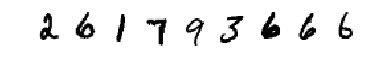

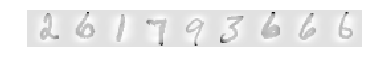

In [44]:
# 随机抽取9组数据进行对比
# 很奇怪scale之后的数字对比度降低了，但识别成功率却提高了
original_image = np.zeros((28, 1))
scaled_image = np.zeros((28, 1))
for idx in np.arange(0, 9):
    random_idx = np.random.randint(high=len(X_train), low=0)
    original_digit = X_train[random_idx]
    scaled_digit = X_train_scaled[random_idx]
    original_image = np.hstack((original_image, original_digit.reshape(28, 28)))
    scaled_image = np.hstack((scaled_image, scaled_digit.reshape(28, 28)))

plt.imshow(original_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()
plt.imshow(scaled_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis("off")
plt.show()

In [45]:
# Error Analysis
# Confusion Matrix
# 其实就是之前的binary classification matrix 分解出来
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5729,    2,   26,    9,   11,   48,   44,    9,   41,    4],
       [   1, 6466,   42,   23,    5,   46,    5,   13,  130,   11],
       [  54,   43, 5335,   90,   84,   27,   91,   62,  156,   16],
       [  44,   42,  133, 5337,    1,  245,   37,   62,  131,   99],
       [  21,   29,   33,    8, 5343,    9,   49,   31,   86,  233],
       [  65,   38,   30,  181,   79, 4607,  111,   32,  174,  104],
       [  32,   23,   42,    2,   49,   97, 5626,    5,   42,    0],
       [  19,   20,   74,   27,   54,   11,    7, 5817,   14,  222],
       [  45,  156,   72,  161,   11,  159,   55,   26, 5015,  151],
       [  38,   36,   27,   91,  150,   35,    2,  210,   72, 5288]])

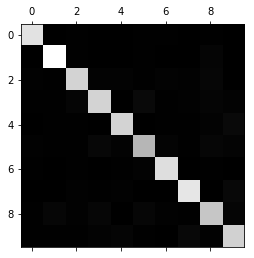

In [46]:
# 直观图例显示
# 颜色较暗的表示该分类的样本个数较少，或者是识别的性能不好
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

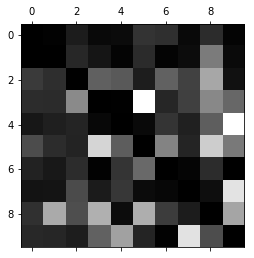

In [47]:
# 检测错误项,颜色越亮表示错误数越高
# 列项表示预测结果，第0列表示所有预测为0的结果中，实际值的分布情况
# 行项表示真实结果，第0行表示所有真实为0的样本中，最终预测的分布情况
row_sums = conf_mx.sum(axis=1, keepdims=True) # 每行求和
norm_conf_mx = conf_mx / row_sums # 标准化，可以让错误更加突出
np.fill_diagonal(norm_conf_mx, 0) # 对角线填充为0，以便更容易测检测出错误项
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# 从图中可以看出8，9的错误率较高，3和5的判断也比较容易混淆

In [48]:
# EXTRA
def plot_digits(instances, images_per_row=10, title=None, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    if title != None:
        plt.title(title)
    plt.axis("off")

In [57]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

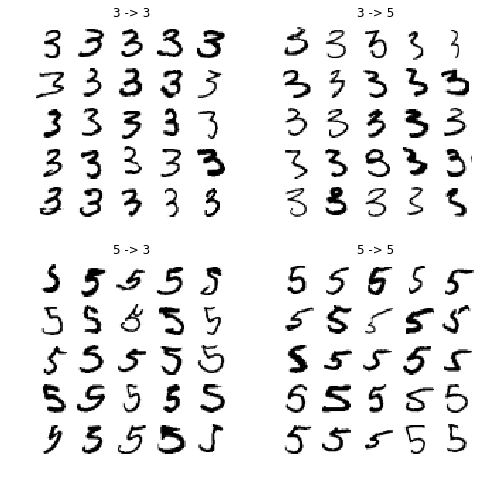

In [49]:
cl_a, cl_b = 3, 5
# 注意，这里是numpy的array操作，不同于Python原生list，这个操作会把结果为True的行过滤出来
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3->3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3->5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5->3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5->5

plt.figure(figsize=(8,8))
# 定义：subplot(nrows, ncols, index, **kwargs)
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5, title="3 -> 3")
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5, title="3 -> 5")
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5, title="5 -> 3")
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5, title="5 -> 5")
plt.show()

# 这里我们使用的是SGDClassifier，这是一个线性分类器，每个像素点都会产生权重，累加成最终结果
# 在错误判断的样例中，3跟5的像素只有细微的差别，因此这种权重累加的方式容易出错
# 也就是说这个分类器对图像的移位和旋转比较敏感，通过确保图像对准中心并且不发生旋转，可以较好地减少误差

# Multilabel Classification
比如说识别一张图片中的多个头像

In [50]:
# 一张图片两个label：1.是否是大数字 2.是否是奇数
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# Train
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Predict
multilabel_pred = knn_clf.predict([some_digit])
print("Multilabel prediction of 5:", multilabel_pred)

Multilabel prediction of 5: [[False  True]]


In [51]:
# F1 Score of multilabel classifier
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)

In [52]:
# 两个标签的平均F1数值
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [53]:
# 带有权重的F1数值，weighted by support (the number of true instances for each label)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

# Multioutput Classification
以图片为例，输出为所有像素点，每个像素点有对应的值，而不仅仅是输出一组标签

In [64]:
# Create noise image
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

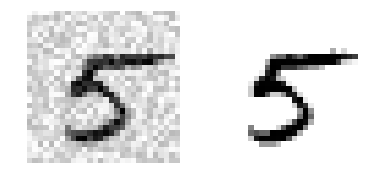

In [65]:
# check noise image
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
# save_fig("noisy_digit_example_plot")
plt.show()

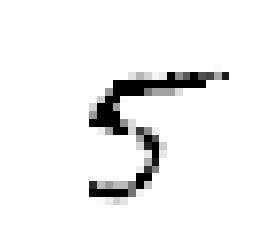

In [66]:
# 这里训练一个Classifier过滤掉噪点
# 输出就是一组class，每个class的值可以为0~255
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)